In [494]:
pwd

'/home/jhin/Attention'

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
import torch.nn.functional as func
import math
import pandas as pd
import os
from transformers import AdamW
from tqdm import tqdm
import numpy as np

epochs = 2

In [2]:
#토큰화 툴과 MLM 모델 정의
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', output_hidden_states = True, output_attentions = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [300]:
pd.read_csv('/home/jhin/Attention/Datasets_YS/CARS_1.csv', encoding = 'ISO-8859-1')

,car_name,reviews_count,fuel_type,engine_displacement,no_cylinder,seating_capacity,transmission_type,fuel_tank_capacity,body_type,rating,starting_price,ending_price,max_torque_nm,max_torque_rpm,max_power_bhp,max_power_rp
0,Maruti Alto K10,51,Petrol,998,3,5.0,Automatic,27.0,Hatchback,4.5,399000,583000,89.0,3500,65.71,5500
1,Maruti Brezza,86,Petrol,1462,4,5.0,Automatic,48.0,SUV,4.5,799000,1396000,136.8,4400,101.65,6000
2,Mahindra Thar,242,Diesel,2184,4,4.0,Automatic,57.0,SUV,4.5,1353000,1603000,300.0,2800,130.00,3750
3,Mahindra XUV700,313,Diesel,2198,4,7.0,Automatic,60.0,SUV,4.5,1318000,2458000,450.0,2800,182.38,3500
4,Mahindra Scorpio-N,107,Diesel,2198,4,7.0,Automatic,57.0,SUV,4.5,1199000,2390000,400.0,2750,172.45,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Mercedes-Benz AMG A 45 S,35,Petrol,1991,4,5.0,Automatic,0.0,Hatchback,4.5,659000,999000,500.0,5250,415.71,6750
199,BMW 3 Series Gran Limousine,3,Petrol,1998,4,5.0,Automatic,59.0,Sedan,4.5,1041000,1041000,400.0,4400,254.79,5000
200,MG Hector Plus,2,Diesel,1956,4,7.0,Manual,60.0,SUV,4.5,1615000,2075000,350.0,2500,167.67,3750
201,Audi RS Q8,9,Petrol,3998,8,5.0,Automatic,85.0,SUV,3.5,21700000,21700000,800.0,4500,591.39,6000


In [297]:
pd.read_csv('/home/jhin/Attention/Datasets_YS/country_level_data_0.csv', encoding = 'ISO-8859-1')

,region_id,country_name,gdp,composition_food_organic_waste_percent,composition_glass_percent,composition_metal_percent,composition_other_percent,composition_paper_cardboard_percent,composition_plastic_percent,composition_rubber_leather_percent,...,waste_treatment_controlled_landfill_percent,waste_treatment_incineration_percent,waste_treatment_landfill_unspecified_percent,waste_treatment_open_dump_percent,waste_treatment_other_percent,waste_treatment_recycling_percent,waste_treatment_sanitary_landfill_landfill_gas_system_percent,waste_treatment_unaccounted_for_percent,waste_treatment_waterways_marine_percent,where_where_is_this_data_measured
0,LCN,Aruba,35563.312500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,89.0,NaN,NaN
1,SAS,Afghanistan,2057.062256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
2,SSF,Angola,8036.690430,51.800000,6.700000,4.400000,11.500000,11.900000,13.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ECS,Albania,13724.058590,51.400000,4.500000,4.800000,15.210000,9.900000,9.600000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some disposal sites
4,ECS,Andorra,43711.800780,31.200000,8.200000,2.600000,11.600000,35.100000,11.300000,NaN,...,NaN,52.1,NaN,NaN,NaN,NaN,NaN,47.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,ECS,Kosovo,9723.561523,42.000000,6.000000,6.000000,20.000000,8.000000,11.000000,NaN,...,66.43,NaN,NaN,33.57,NaN,NaN,NaN,NaN,NaN,NaN
213,MEA,"Yemen, Rep.",8269.671875,65.000000,1.000000,6.000000,6.000000,7.000000,10.000000,1.0,...,12.00,NaN,NaN,25.00,NaN,8.0,NaN,47.0,8.0,Other
214,SSF,South Africa,12666.607420,16.381655,5.200216,16.910461,45.020646,9.396918,7.090104,NaN,...,72.00,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN
215,SSF,Zambia,3201.289307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
with open('/home/jhin/Attention/Datasets_YS/steam_games.csv', encoding = 'ISO-8859-1') as f:
    lines = f.readlines()
    
for line in lines[:5]:
    print(len(line.split(';')))

22
22
22
22
22


In [4]:
# Netflix

In [5]:
# for col in Netflix.columns:
#     print(Netflix[col])

In [6]:
# Netflix['title'].dtypes

In [7]:
# Netflix=pd.read_csv('/home/jhin/Attention/Netflix Shows.csv', encoding = 'ISO-8859-1')
# for col in Netflix.columns:
#     if (Netflix[col].dtypes=="int64" or Netflix[col].dtypes=="float64"):
#         bins=np.linspace(Netflix[col].min(),Netflix[col].max(),5)
#         print(bins)
#         Netflix[col]=np.digitize(Netflix[col],bins)
# print(Netflix)


In [16]:
# 실험에 사용할 데이터 불러오기
del_words=["id","_id","unnamed: 0"]
file_list = os.listdir('/home/jhin/Attention/Datasets_YS')
file_list.remove('.ipynb_checkpoints')
file_list.remove('.kaggle')
data = []
for i in range(len(file_list)):
    print(file_list[i])
    try:
        data.append(pd.read_csv('/home/jhin/Attention/Datasets_YS/{}'.format(file_list[i]), encoding = 'ISO-8859-1')[:50])
    except pd.errors.ParserError:
        data.append(pd.read_csv('/home/jhin/Attention/Datasets_YS/{}'.format(file_list[i]), encoding = 'ISO-8859-1',sep=';')[:50])

        
        
    data[i] = data[i].fillna('.')
    
    for col in data[i].columns:        
        if (data[i][col].dtypes=="int64" or data[i][col].dtypes=="float64"):
            Q1 = np.percentile(data[i][col], 20)
            Q2 = np.percentile(data[i][col], 40)
            Q3 = np.percentile(data[i][col], 60)
            Q4 = np.percentile(data[i][col], 80)
            data[i][col]=np.where(data[i][col]>=Q4,'very high',np.where(data[i][col]>=Q3,'high',np.where(data[i][col]>=Q2,'medium',np.where(data[i][col]>=Q1,'low','very low'))))
            data[i]=data[i].astype({col:'object'})
        if any(del_word in col.lower() for del_word in del_words):
            data[i].drop([col],axis=1,inplace=True)
           

TravelInsurancePrediction.csv
Covid Live.csv
indian_food.csv
android_games_224games.csv
food-inspections.csv
Food Composition.csv
seattle_01.csv
netflix1.csv
commodity_prices.csv
kbopitchingdata.csv
country_level_data_0.csv
TikTok_songs_2021.csv
chess_games.csv
vgsales.csv
android-games.csv
CARS_1.csv
resultbook2.csv
CO2_emission.csv
chip_dataset.csv
top_defense_manufacturers.csv
hotel_bookings.csv
Hotel_Reviews.csv
tripadvisor_european_restaurants.csv
global_transport.csv
Food_Preference.csv
ski_hotels.csv
wfp_market_food_prices.csv
Food_Production.csv
listings.csv
wiki_movie_plots_deduped.csv
2019_world_happiness.csv
anime.csv
anime_rating.csv
USA-latlon.csv
all_games.csv
imdb_christmas_movies_2017-22.csv
Twitch_game_data.csv
AB_NYC_2019.csv
goibibo_com-travel_sample.csv
financial_sentimental.csv
Asteroid.csv
Crop_recommendation.csv
travel insurance.csv
ramen-ratings.csv
Customertravel.csv
DOHMH_New_York_City_Restaurant_Inspection_Results.csv
Holiday_Package.csv
avocado.csv
winequali

/home/jhin/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


superbowl.csv
US_Accidents_Dec21_updated.csv
water_potability.csv
europe.csv
Airline_Passenger_Satisfaction.csv
DelayedFlights.csv
genre_region_totals.csv
uber.csv
bournemouth_venues.csv
housePrice.csv
Airports.csv
walmart_2018_11_06.csv
Datafiniti_Fast_Food_Restaurants.csv


In [17]:
data[0]

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,high,Government Sector,Yes,very low,high,very high,No,No,medium
1,high,Private Sector/Self Employed,Yes,high,very high,high,No,No,medium
2,very high,Private Sector/Self Employed,Yes,very low,medium,very high,No,No,very high
3,low,Private Sector/Self Employed,Yes,low,low,very high,No,No,medium
4,low,Private Sector/Self Employed,Yes,low,very high,very high,Yes,No,medium
5,very low,Private Sector/Self Employed,No,high,medium,high,No,No,medium
6,high,Government Sector,Yes,high,medium,high,No,No,medium
7,high,Private Sector/Self Employed,Yes,high,low,high,Yes,Yes,very high
8,low,Private Sector/Self Employed,Yes,very high,high,very high,Yes,Yes,very high
9,very high,Government Sector,Yes,medium,low,high,Yes,No,medium


In [18]:
for i in range(len(file_list)):
    print(i, " ", file_list[i])

0   TravelInsurancePrediction.csv
1   Covid Live.csv
2   indian_food.csv
3   android_games_224games.csv
4   food-inspections.csv
5   Food Composition.csv
6   seattle_01.csv
7   netflix1.csv
8   commodity_prices.csv
9   kbopitchingdata.csv
10   country_level_data_0.csv
11   TikTok_songs_2021.csv
12   chess_games.csv
13   vgsales.csv
14   android-games.csv
15   CARS_1.csv
16   resultbook2.csv
17   CO2_emission.csv
18   chip_dataset.csv
19   top_defense_manufacturers.csv
20   hotel_bookings.csv
21   Hotel_Reviews.csv
22   tripadvisor_european_restaurants.csv
23   global_transport.csv
24   Food_Preference.csv
25   ski_hotels.csv
26   wfp_market_food_prices.csv
27   Food_Production.csv
28   listings.csv
29   wiki_movie_plots_deduped.csv
30   2019_world_happiness.csv
31   anime.csv
32   anime_rating.csv
33   USA-latlon.csv
34   all_games.csv
35   imdb_christmas_movies_2017-22.csv
36   Twitch_game_data.csv
37   AB_NYC_2019.csv
38   goibibo_com-travel_sample.csv
39   financial_sentimental.csv


In [19]:
# data_266 = data[266].drop(['publishedAt', 'categoryId', 'trending_date', 'view_count', 'likes', 'dislikes', 'comment_count'], axis=1)
# data[266] = data_266

In [20]:
import nltk
nltk.download('punkt')
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /home/jhin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml', filename = 'ted_en-20160408.xml')

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f0665d0c1c0>)

In [22]:
targetXML = open('ted_en-20160408.xml', 'r', encoding = 'UTF8')
target_text = etree.parse(targetXML)

parse_text = '\n'.join(target_text.xpath('//content/text()'))
content_text = re.sub(r'\([^)]*\)', '', parse_text)
sent_text = sent_tokenize(content_text)
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)
result = [word_tokenize(sentence) for sentence in normalized_text]

In [23]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [24]:
from gensim.models import Word2Vec
model_head = Word2Vec(sentences = result, size = 768, window = 10, min_count = 5, workers = 5, sg = 0)

In [25]:
def tag_embedding(a):
    tag_emb = []
    tag_raw = nltk.word_tokenize(category['tag'][a])
    sum = np.zeros(768)
    for i in range(len(tag_raw)):
        try:
            sum = sum + model_head.wv.get_vector(tag_raw[i])
        except KeyError:
            continue
    return sum/(np.zeros(768)+len(sum))

In [26]:
def heading_embedding(dataset):
    columns = dataset.columns
    lower = []
    sum = np.zeros(768)
    for i in range(len(columns)):
        lower.append(columns[i].lower())
        try:
            sum = sum + model_head.wv.get_vector(lower[i])
        except KeyError:
            continue
    return sum/(np.zeros(768)+len(columns))

In [27]:
def record_embedding(dataset):
    columns = dataset.columns
    text = []
    for i in range(len(dataset)):
        record = []
        for j in range(len(columns)):
            record.append(dataset.iloc[i][j])
        record = " ".join(map(str,record))
        text.append(record)
    inputs = tokenizer(text, return_tensors = 'pt', padding = True, truncation = True)
    inputs['labels'] = inputs.input_ids.detach().clone()
    
    #input_ids와 같은 크기의 임의의 벡터를 생성해서 0.15보다 낮은 수를 가진 요소를 masking
    rand = torch.rand(inputs.input_ids.shape)
    mask_arr = rand < 0.15
    mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102)
    selection = []

    for i in range(inputs.input_ids.shape[0]):
        selection.append(torch.flatten(mask_arr[i].nonzero()).tolist())
    for i in range(inputs.input_ids.shape[0]):
        inputs.input_ids[i, selection[i]] = 103
    device = torch.device('cpu')
    model.to(device)
    model.train()
    dataset = DisneyDataset(inputs)
    loader = torch.utils.data.DataLoader(dataset, batch_size = 800, shuffle = True)
    optim = AdamW(model.parameters(), lr = 5e-5)
    for epoch in range(epochs):
        loop = tqdm(loader, leave = True)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        loss.backward()
        optim.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss = loss.item())
#총 800개 record 각각에 대해 84개의 token으로 구성된 input
#84개는 최대 문장 길이를 고려한 max_length이고, 빈 부분을 padding한 것
    output_emb = outputs.hidden_states[12]
    sum_token = torch.zeros(len(outputs.hidden_states[12][0][0]))
    sum_record = torch.zeros(len(outputs.hidden_states[12][0][0]))
    for i in range(len(outputs.hidden_states[12])):  #800개의 record
        for j in range(len(outputs.hidden_states[12][0])):   #84개의 token
            sum_token += outputs.hidden_states[12][i][j]
        avg_token = sum_token / len(outputs.hidden_states[12])
        sum_record += avg_token
    avg_record = sum_record / len(outputs.hidden_states[12][0])
    return avg_record

In [28]:
class DisneyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [29]:
import datetime

In [30]:
embedding_vector = []
for i in range(len(data)):
    embedding_vector.append(record_embedding(data[i]))
    now = datetime.datetime.now()
    print(i, now)

/home/jhin/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]
<ipython-input-28-6f31f7c0d17f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}

  0%|          | 0/1 [00:00<?, ?it/s]

0 2022-12-05 17:49:58.621390




  0%|          | 0/1 [00:00<?, ?it/s]

1 2022-12-05 17:50:03.758832




  0%|          | 0/1 [00:00<?, ?it/s]


2 2022-12-05 17:50:05.773375



Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it, loss=6.02]


3 2022-12-05 17:50:08.562906


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:48<00:00, 48.16s/it, loss=6.75]


4 2022-12-05 17:50:58.423877


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:25<00:00, 25.65s/it, loss=3.91]


5 2022-12-05 17:51:25.065784


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 2022-12-05 17:51:32.172579




Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, loss=3.34]


7 2022-12-05 17:51:34.690814


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it, loss=1.96]


8 2022-12-05 17:51:38.363230


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, loss=2.29]


9 2022-12-05 17:51:42.018387


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

10 2022-12-05 17:51:49.270788




Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it, loss=2.45]


11 2022-12-05 17:51:52.212654


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 2022-12-05 17:52:25.829448




  0%|          | 0/1 [00:00<?, ?it/s]

13 2022-12-05 17:52:27.613958




  0%|          | 0/1 [00:00<?, ?it/s]

14 2022-12-05 17:52:29.746739




Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, loss=1.6]


15 2022-12-05 17:52:31.913563


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:24<00:00, 24.04s/it, loss=1.65]


16 2022-12-05 17:52:56.754269


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

17 2022-12-05 17:53:26.392514




  0%|          | 0/1 [00:00<?, ?it/s]


18 2022-12-05 17:53:28.837686



Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, loss=0.995]


19 2022-12-05 17:53:32.683382


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it, loss=0.804]


20 2022-12-05 17:53:37.167587


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:44<00:00, 44.77s/it, loss=1.32]


21 2022-12-05 17:54:23.455363


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:38<00:00, 38.96s/it, loss=0.773]


22 2022-12-05 17:55:03.986558


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

23 2022-12-05 17:55:10.013664




Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, loss=1.09]


24 2022-12-05 17:55:11.949150


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

25 2022-12-05 17:55:17.481830




  0%|          | 0/1 [00:00<?, ?it/s]

26 2022-12-05 17:55:18.961969




  0%|          | 0/1 [00:00<?, ?it/s]

27 2022-12-05 17:55:23.061678




Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, loss=0.724]


28 2022-12-05 17:55:25.883843


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

29 2022-12-05 17:56:18.901310




  0%|          | 0/1 [00:00<?, ?it/s]


30 2022-12-05 17:56:21.014607



  0%|          | 0/1 [00:00<?, ?it/s]


31 2022-12-05 17:56:24.114984



  0%|          | 0/1 [00:00<?, ?it/s]


32 2022-12-05 17:56:24.796378



Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, loss=0.409]


33 2022-12-05 17:56:25.634310


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:34<00:00, 34.50s/it, loss=0.446]


34 2022-12-05 17:57:01.308788


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

35 2022-12-05 17:57:38.143315




  0%|          | 0/1 [00:00<?, ?it/s]

36 2022-12-05 17:57:40.272886




Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it, loss=0.52]


37 2022-12-05 17:57:42.744944


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

38 2022-12-05 17:58:32.524199




Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it, loss=0.379]


39 2022-12-05 17:58:35.782169


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


40 2022-12-05 17:58:39.576373



  0%|          | 0/1 [00:00<?, ?it/s]


41 2022-12-05 17:58:40.779009



  0%|          | 0/1 [00:00<?, ?it/s]


42 2022-12-05 17:58:42.500079



  0%|          | 0/1 [00:00<?, ?it/s]


43 2022-12-05 17:58:44.108630



Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, loss=0.477]


44 2022-12-05 17:58:45.907970


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

45 2022-12-05 17:58:54.211109




  0%|          | 0/1 [00:00<?, ?it/s]

46 2022-12-05 17:58:56.727177




  0%|          | 0/1 [00:00<?, ?it/s]


47 2022-12-05 17:58:58.910363



  0%|          | 0/1 [00:00<?, ?it/s]


48 2022-12-05 17:58:59.946941



Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it, loss=0.367]


49 2022-12-05 17:59:02.464369


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

50 2022-12-05 17:59:10.894513




  0%|          | 0/1 [00:00<?, ?it/s]

51 2022-12-05 17:59:20.899480



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


52 2022-12-05 17:59:25.752614



Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, loss=0.55]


53 2022-12-05 17:59:26.678791


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it, loss=0.648]


54 2022-12-05 17:59:29.517298


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

55 2022-12-05 18:00:00.579013




Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=0.483]


56 2022-12-05 18:00:02.610416


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

57 2022-12-05 18:00:09.821271




  0%|          | 0/1 [00:00<?, ?it/s]


58 2022-12-05 18:00:11.945313



Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it, loss=0.48]


59 2022-12-05 18:00:13.706645


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, loss=0.408]


60 2022-12-05 18:00:16.488976


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


61 2022-12-05 18:00:20.283998



  0%|          | 0/1 [00:00<?, ?it/s]


62 2022-12-05 18:00:21.188779



  0%|          | 0/1 [00:00<?, ?it/s]


63 2022-12-05 18:00:23.445913



  0%|          | 0/1 [00:00<?, ?it/s]


64 2022-12-05 18:00:24.604719



  0%|          | 0/1 [00:00<?, ?it/s]


65 2022-12-05 18:00:25.919790



Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, loss=0.409]


66 2022-12-05 18:00:27.699392


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.25s/it, loss=0.314]


67 2022-12-05 18:00:33.342135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 1/1 [00:49<00:00, 49.74s/it, loss=0.286]


68 2022-12-05 18:01:24.745843


In [31]:
category = pd.read_csv('/home/jhin/Attention/Dataset_tag_YS.csv')

In [32]:
result_vector = []
for i in range(len(data)):
    tag = torch.Tensor(tag_embedding(i))
    norm_tag = func.normalize(tag, dim = 0)
    heading = torch.Tensor(heading_embedding(data[i]))
    norm_heading = func.normalize(heading, dim = 0)
    norm_embedding_vector = func.normalize(embedding_vector[i], dim = 0)
    result_vector.append(norm_tag*0.2 + norm_heading*0.2 + norm_embedding_vector[i]*0.6)

In [452]:
print(result_vector[0].size(), len(result_vector))

torch.Size([768]) 69


In [79]:
# for i in range(len(result_vector)):
#     print(i, " ", result_vector[i])
# data[1]

In [117]:
# Train 라벨 데이터 생성
for i in range(19,len(data)):
    for j in range(19,len(data)):
        print(file_list[i] + "," + file_list[j]+",")

top_defense_manufacturers.csv,top_defense_manufacturers.csv,
top_defense_manufacturers.csv,hotel_bookings.csv,
top_defense_manufacturers.csv,Hotel_Reviews.csv,
top_defense_manufacturers.csv,tripadvisor_european_restaurants.csv,
top_defense_manufacturers.csv,global_transport.csv,
top_defense_manufacturers.csv,Food_Preference.csv,
top_defense_manufacturers.csv,ski_hotels.csv,
top_defense_manufacturers.csv,wfp_market_food_prices.csv,
top_defense_manufacturers.csv,Food_Production.csv,
top_defense_manufacturers.csv,listings.csv,
top_defense_manufacturers.csv,wiki_movie_plots_deduped.csv,
top_defense_manufacturers.csv,2019_world_happiness.csv,
top_defense_manufacturers.csv,anime.csv,
top_defense_manufacturers.csv,anime_rating.csv,
top_defense_manufacturers.csv,USA-latlon.csv,
top_defense_manufacturers.csv,all_games.csv,
top_defense_manufacturers.csv,imdb_christmas_movies_2017-22.csv,
top_defense_manufacturers.csv,Twitch_game_data.csv,
top_defense_manufacturers.csv,AB_NYC_2019.csv,
top_defens

Airports.csv,USA-latlon.csv,
Airports.csv,all_games.csv,
Airports.csv,imdb_christmas_movies_2017-22.csv,
Airports.csv,Twitch_game_data.csv,
Airports.csv,AB_NYC_2019.csv,
Airports.csv,goibibo_com-travel_sample.csv,
Airports.csv,financial_sentimental.csv,
Airports.csv,Asteroid.csv,
Airports.csv,Crop_recommendation.csv,
Airports.csv,travel insurance.csv,
Airports.csv,ramen-ratings.csv,
Airports.csv,Customertravel.csv,
Airports.csv,DOHMH_New_York_City_Restaurant_Inspection_Results.csv,
Airports.csv,Holiday_Package.csv,
Airports.csv,avocado.csv,
Airports.csv,winequality-red.csv,
Airports.csv,top50.csv,
Airports.csv,Pizza_Restaurants_and_the_Pizza_They_Sell.csv,
Airports.csv,coffee-listings-from-all-walmart-stores.csv,
Airports.csv,nfl_stadiums.csv,
Airports.csv,nfl_teams.csv,
Airports.csv,spreadspoke_scores.csv,
Airports.csv,steam_games.csv,
Airports.csv,superbowl.csv,
Airports.csv,US_Accidents_Dec21_updated.csv,
Airports.csv,water_potability.csv,
Airports.csv,europe.csv,
Airports.csv,Airli

In [118]:
# Test 라벨 데이터 생성
for i in range(19):
    for j in range(19):
        print(file_list[i] + "," + file_list[j]+",")

TravelInsurancePrediction.csv,TravelInsurancePrediction.csv,
TravelInsurancePrediction.csv,Covid Live.csv,
TravelInsurancePrediction.csv,indian_food.csv,
TravelInsurancePrediction.csv,android_games_224games.csv,
TravelInsurancePrediction.csv,food-inspections.csv,
TravelInsurancePrediction.csv,Food Composition.csv,
TravelInsurancePrediction.csv,seattle_01.csv,
TravelInsurancePrediction.csv,netflix1.csv,
TravelInsurancePrediction.csv,commodity_prices.csv,
TravelInsurancePrediction.csv,kbopitchingdata.csv,
TravelInsurancePrediction.csv,country_level_data_0.csv,
TravelInsurancePrediction.csv,TikTok_songs_2021.csv,
TravelInsurancePrediction.csv,chess_games.csv,
TravelInsurancePrediction.csv,vgsales.csv,
TravelInsurancePrediction.csv,android-games.csv,
TravelInsurancePrediction.csv,CARS_1.csv,
TravelInsurancePrediction.csv,resultbook2.csv,
TravelInsurancePrediction.csv,CO2_emission.csv,
TravelInsurancePrediction.csv,chip_dataset.csv,
Covid Live.csv,TravelInsurancePrediction.csv,
Covid Live.c

In [181]:
from IPython.display import clear_output 
import time
#Fusion_pos를 정하기 위해 2개의 테이블씩 보여주는 코드
for i in range(25,len(data)):
    for j in range(19,len(data)):
        print(file_list[i] + "," + file_list[j]+"\n")
        try:
            print(pd.read_csv('/home/jhin/Attention/Datasets_YS/{}'.format(file_list[i]), encoding = 'ISO-8859-1'))
        except pd.errors.ParserError:
            print(pd.read_csv('/home/jhin/Attention/Datasets_YS/{}'.format(file_list[i]), encoding = 'ISO-8859-1',sep=';'))
        try:
            print(pd.read_csv('/home/jhin/Attention/Datasets_YS/{}'.format(file_list[j]), encoding = 'ISO-8859-1'))
        except pd.errors.ParserError:
            print(pd.read_csv('/home/jhin/Attention/Datasets_YS/{}'.format(file_list[j]), encoding = 'ISO-8859-1',sep=';'))
        
        time.sleep(1)
        input()
        clear_output()



ski_hotels.csv,top_defense_manufacturers.csv

     Unnamed: 0   country        resort                   hotel  price (Â£)  \
0             0     italy  bardonecchia         residence-tabor         550   
1             1     italy  bardonecchia  residence-villa-frejus         561   
2             2  bulgaria        bansko              hotel-mura         566   
3             3  bulgaria      borovets           hotel-samokov         574   
4             4  bulgaria        bansko     hotel-lion---bansko         596   
..          ...       ...           ...                     ...         ...   
402         402    france   val-thorens          hotel-fitz-roy        2216   
403         403   austria        ischgl            hotel-fliana        2258   
404         404   austria        ischgl         hotel-elisabeth        2420   
405         405   austria        ischgl     hotel-trofana-royal        2484   
406         406   austria   hinterglemm     hotel-alpine-palace        2517   

    d

KeyboardInterrupt: Interrupted by user

In [138]:
# Train / Test 에서 라벨 데이터를 추출하는 코드
My_Fus_pos = pd.read_csv('/home/jhin/Attention/Fusion_pos_train.csv', encoding = 'ISO-8859-1')
My_Fus_pos[['Fusion_pos']]
Any_Temp_List=[]
for i in range(2500):
    Any_Temp_List.append(My_Fus_pos.iloc[i]['Fusion_pos'])
Any_Temp_List = np.array(Any_Temp_List)
Any_Temp_List.shape #최종적으로 나온 Any_Temp_List 어레이를 가져가서 라벨로 사용함

(2500,)

In [113]:
#print((result_vector[0].detach().numpy() + result_vector[0].detach().numpy()).reshape(2,768))
result_vector_train=[]
result_vector_test=[]
for i in range(19,len(data)):
    for j in range(19,len(data)):
        result_vector_train.append( np.stack((result_vector[i].detach().numpy(),result_vector[j].detach().numpy()),axis=0) )
for i in range(19):
    for j in range(19):
        result_vector_test.append( np.stack((result_vector[i].detach().numpy(),result_vector[j].detach().numpy()),axis=0) )

result_vector_train = np.array(result_vector_train)
result_vector_test = np.array(result_vector_test)


print(np.shape(result_vector_train))
print(np.shape(result_vector_test))

(2500, 2, 768)
(361, 2, 768)


In [430]:
train_label_df = pd.read_csv('/home/jhin/Attention/Fusion_pos_train.csv', encoding = 'ISO-8859-1')
test_label_df = pd.read_csv('/home/jhin/Attention/Fusion_pos_test.csv', encoding = 'ISO-8859-1')

In [432]:
result_vector_train_label=train_label_df['Fusion_pos'].values# 내가 직접 보고 정해야 하는 값
result_vector_test_label=test_label_df['Fusion_pos'].values # 내가 직접 보고 정해야 하는 값

In [400]:
#융합 가능 / 불가능 2개의 라벨
temp=[]
for i in result_vector_train_label:
    if i>1 :
        temp.append(1)
    elif i==1:
        temp.append(0)
result_vector_train_label_bin=np.array(temp)

temp=[]
for i in result_vector_test_label:
    if i>1 :
        temp.append(1)
    elif i==1:
        temp.append(0)
result_vector_test_label_bin=np.array(temp)

In [418]:
#융합 가능도 상 / 중 / 하 3개의 라벨
temp=[]
for i in result_vector_train_label:
    if i>5 :
        temp.append(2)
    elif i>1:
        temp.append(1)
    elif i==1:
        temp.append(0)
result_vector_train_label_tri=np.array(temp)

temp=[]
for i in result_vector_test_label:
    if i>5 :
        temp.append(2)
    elif i>1:
        temp.append(1)
    elif i==1:
        temp.append(0)
result_vector_test_label_tri=np.array(temp)

In [487]:
## 학습을 원활하게 하기 위해 융합 가능 : 불가능 라벨을 1:5정도로 학습데이터를 변경
index_of_one=[]
for i in range(len(result_vector_train_label)):
    if result_vector_train_label[i]==1 :
        index_of_one.append(i)

        
       
import random

rdm_index_train = random.sample(index_of_one,2405)


for i in range(25):
    for i in range(len(result_vector_train_label)):
        if result_vector_train_label[i]!=1 :
            rdm_index_train.append(i)
        
new_result_vector_train=[]    
new_result_vector_train_label=[]

for idx in rdm_index_train:
    new_result_vector_train.append(result_vector_train[idx])
    new_result_vector_train_label.append(result_vector_train_label_bin[idx])

new_result_vector_train=np.array(new_result_vector_train)
new_result_vector_train_label=np.array(new_result_vector_train_label)

In [478]:
# DNN 모듈 code

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2, 768)),
  tf.keras.layers.Dense(768, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(192, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(96, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(2, activation='softmax')
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # 다항 분류에서 출력 softmax일때 자주 사용
model.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])


In [488]:
model.fit(new_result_vector_train,  new_result_vector_train_label, batch_size=8, epochs=5)

Epoch 1/5
598/598 [==============================] - 2s 4ms/step - loss: 0.4405 - accuracy: 0.8079
Epoch 2/5
598/598 [==============================] - 2s 4ms/step - loss: 0.3771 - accuracy: 0.8347
Epoch 3/5
598/598 [==============================] - 2s 4ms/step - loss: 0.3576 - accuracy: 0.8464
Epoch 4/5
598/598 [==============================] - 2s 4ms/step - loss: 0.3293 - accuracy: 0.8626
Epoch 5/5
598/598 [==============================] - 2s 3ms/step - loss: 0.2997 - accuracy: 0.8789


In [489]:
model.evaluate(result_vector_test, result_vector_test_label_bin, verbose=2)

12/12 - 0s - loss: 0.4310 - accuracy: 0.9224 - 63ms/epoch - 5ms/step


[0.4310382902622223, 0.9224376678466797]

In [490]:
y_prob = model.predict(result_vector_test, verbose=0) 
predicted_bin = y_prob.argmax(axis=-1)
predicted_bin

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [493]:
for i in range(len(predicted_bin)):
    if predicted_bin[i] == 1:
        print(i+2)
        

2
5
15
22
42
57
59
62
72
78
82
85
102
113
115
122
139
142
162
182
202
206
222
242
249
252
262
278
282
288
302
311
322
324
327
342
347
349
360
362


In [491]:
from sklearn.metrics import roc_auc_score 
roc_auc = roc_auc_score(result_vector_test_label_bin, predicted_bin) 
print("ROC AUC Score: {}".format(roc_auc))

ROC AUC Score: 0.8340413318025259


In [34]:
from numpy import dot
from numpy.linalg import norm

In [35]:
def cos_sim(a, b):
    return abs(dot(a, b)/(norm(a)*norm(b)))

In [36]:
for i in range(len(data)):
    for j in range(i+1, len(data)):
        A = result_vector[i].tolist()
        B = result_vector[j].tolist()
        print(file_list[i],"#", file_list[j], ":", cos_sim(A, B), "#", "dist : ", math.dist(A, B))

TravelInsurancePrediction.csv # Covid Live.csv : 0.8285946954443565 # dist :  0.45897939632990387
TravelInsurancePrediction.csv # indian_food.csv : 0.05163411622633039 # dist :  0.5297512557031867
TravelInsurancePrediction.csv # android_games_224games.csv : 0.8587015425041497 # dist :  0.26911835705616116
TravelInsurancePrediction.csv # food-inspections.csv : 0.8890441739223176 # dist :  0.21898723252750227
TravelInsurancePrediction.csv # Food Composition.csv : 0.21977240408229506 # dist :  0.6610230769560103
TravelInsurancePrediction.csv # seattle_01.csv : 0.794095388233582 # dist :  0.320738119321209
TravelInsurancePrediction.csv # netflix1.csv : 0.8538913008668338 # dist :  0.2483110661554788
TravelInsurancePrediction.csv # commodity_prices.csv : 0.8280094680097726 # dist :  0.6505820175622806
TravelInsurancePrediction.csv # kbopitchingdata.csv : 0.5186077286166414 # dist :  0.7127696546803219
TravelInsurancePrediction.csv # country_level_data_0.csv : 0.6465755184934429 # dist :  0.

indian_food.csv # imdb_christmas_movies_2017-22.csv : 0.10411143406939065 # dist :  0.6775117071745744
indian_food.csv # Twitch_game_data.csv : 0.1898427332715414 # dist :  0.9386459019802766
indian_food.csv # AB_NYC_2019.csv : 0.48616699187415974 # dist :  0.21593240861349658
indian_food.csv # goibibo_com-travel_sample.csv : 0.037632322053855825 # dist :  0.5664208948876646
indian_food.csv # financial_sentimental.csv : 0.37998771727318176 # dist :  0.6413324739668429
indian_food.csv # Asteroid.csv : 0.32078596837657025 # dist :  0.7429749983081726
indian_food.csv # Crop_recommendation.csv : 0.09915988974204248 # dist :  0.33575259594254236
indian_food.csv # travel insurance.csv : 0.3932724665651389 # dist :  0.6561064785556235
indian_food.csv # ramen-ratings.csv : 0.016485795661821633 # dist :  0.5677290567108126
indian_food.csv # Customertravel.csv : 0.42036113854262597 # dist :  0.38955460596477265
indian_food.csv # DOHMH_New_York_City_Restaurant_Inspection_Results.csv : 0.351324425

Food Composition.csv # Food_Production.csv : 0.6336650746754396 # dist :  0.6807570079086793
Food Composition.csv # listings.csv : 0.5041493551633255 # dist :  0.911635412850659
Food Composition.csv # wiki_movie_plots_deduped.csv : 0.1253308815643221 # dist :  0.6389547172420119
Food Composition.csv # 2019_world_happiness.csv : 0.5037077548680872 # dist :  0.9953725860173136
Food Composition.csv # anime.csv : 0.10195911830316302 # dist :  0.3975583146015079
Food Composition.csv # anime_rating.csv : 0.3324455376394347 # dist :  0.6115123012096327
Food Composition.csv # USA-latlon.csv : 0.5739272552880486 # dist :  0.3355805818148459
Food Composition.csv # all_games.csv : 0.6154219722859199 # dist :  0.2948603083780185
Food Composition.csv # imdb_christmas_movies_2017-22.csv : 0.4981899345239266 # dist :  0.8653502059846271
Food Composition.csv # Twitch_game_data.csv : 0.550519563011461 # dist :  1.1199333198880679
Food Composition.csv # AB_NYC_2019.csv : 0.12858398150747533 # dist :  0.

commodity_prices.csv # steam_games.csv : 0.9467744936099919 # dist :  0.33776759940432893
commodity_prices.csv # superbowl.csv : 0.40112830405446087 # dist :  1.100694922782763
commodity_prices.csv # US_Accidents_Dec21_updated.csv : 0.9397548282443554 # dist :  1.9959887528637639
commodity_prices.csv # water_potability.csv : 0.9182306884806216 # dist :  1.6003842902082142
commodity_prices.csv # europe.csv : 0.42949774539285074 # dist :  0.9003096320633386
commodity_prices.csv # Airline_Passenger_Satisfaction.csv : 0.6965940531957703 # dist :  0.7683812278530306
commodity_prices.csv # DelayedFlights.csv : 0.538871571171632 # dist :  1.2230447654255987
commodity_prices.csv # genre_region_totals.csv : 0.9061754936006425 # dist :  1.6259267092510303
commodity_prices.csv # uber.csv : 0.9375502927870076 # dist :  1.5709468002148408
commodity_prices.csv # bournemouth_venues.csv : 0.979303678465446 # dist :  1.3440576097969825
commodity_prices.csv # housePrice.csv : 0.9370186175805322 # dist :

chess_games.csv # nfl_stadiums.csv : 0.4151292726471401 # dist :  0.27389235392243155
chess_games.csv # nfl_teams.csv : 0.6484554173372825 # dist :  0.2368862220467269
chess_games.csv # spreadspoke_scores.csv : 0.45138968725625306 # dist :  0.533371450567066
chess_games.csv # steam_games.csv : 0.598708988578703 # dist :  1.0014211427614288
chess_games.csv # superbowl.csv : 0.3948110790669407 # dist :  0.27238508983930887
chess_games.csv # US_Accidents_Dec21_updated.csv : 0.6531280568161971 # dist :  0.8896095327406947
chess_games.csv # water_potability.csv : 0.5883310609254634 # dist :  0.5340352090696557
chess_games.csv # europe.csv : 0.2108246256741587 # dist :  0.4421589942182562
chess_games.csv # Airline_Passenger_Satisfaction.csv : 0.45687149213318007 # dist :  0.5627086166133535
chess_games.csv # DelayedFlights.csv : 0.43437214544612324 # dist :  0.34390001862018205
chess_games.csv # genre_region_totals.csv : 0.6624393695997582 # dist :  0.539126707374951
chess_games.csv # uber.c

android-games.csv # Airports.csv : 0.6652766625564985 # dist :  0.2869561383999613
android-games.csv # walmart_2018_11_06.csv : 0.7151522397959768 # dist :  0.551919992670814
android-games.csv # Datafiniti_Fast_Food_Restaurants.csv : 0.6272055862931437 # dist :  2.1033825694877404
CARS_1.csv # resultbook2.csv : 0.23145937074115874 # dist :  0.8787629586890526
CARS_1.csv # CO2_emission.csv : 0.3253983565989609 # dist :  0.6951784943960168
CARS_1.csv # chip_dataset.csv : 0.36945844884323836 # dist :  0.9272040541763565
CARS_1.csv # top_defense_manufacturers.csv : 0.9623599164996859 # dist :  0.20173088853846385
CARS_1.csv # hotel_bookings.csv : 0.9614084126302118 # dist :  0.2039891058513956
CARS_1.csv # Hotel_Reviews.csv : 0.6785625274510529 # dist :  1.0157217474061677
CARS_1.csv # tripadvisor_european_restaurants.csv : 0.4383000933670788 # dist :  0.6605795740497191
CARS_1.csv # global_transport.csv : 0.9191881085494219 # dist :  0.48003195940329463
CARS_1.csv # Food_Preference.csv : 

CO2_emission.csv # imdb_christmas_movies_2017-22.csv : 0.29254598975123675 # dist :  0.5970655639410026
CO2_emission.csv # Twitch_game_data.csv : 0.3052199536592021 # dist :  0.8376503337699253
CO2_emission.csv # AB_NYC_2019.csv : 0.40308586826103465 # dist :  0.23146354641054773
CO2_emission.csv # goibibo_com-travel_sample.csv : 0.37855717296939817 # dist :  0.49529762294385693
CO2_emission.csv # financial_sentimental.csv : 0.07468602680399708 # dist :  0.7348683045971232
CO2_emission.csv # Asteroid.csv : 0.1012247085560039 # dist :  0.8290872818148328
CO2_emission.csv # Crop_recommendation.csv : 0.5898209515361286 # dist :  0.23352208318860068
CO2_emission.csv # travel insurance.csv : 0.08182567457391823 # dist :  0.7540930349865284
CO2_emission.csv # ramen-ratings.csv : 0.3368172345938921 # dist :  0.5016481619773706
CO2_emission.csv # Customertravel.csv : 0.026595947811377654 # dist :  0.4795054393012912
CO2_emission.csv # DOHMH_New_York_City_Restaurant_Inspection_Results.csv : 0.0

Hotel_Reviews.csv # Crop_recommendation.csv : 0.4713198338645687 # dist :  0.5573201601516858
Hotel_Reviews.csv # travel insurance.csv : 0.8064927725545075 # dist :  0.4688358988971241
Hotel_Reviews.csv # ramen-ratings.csv : 0.7211975161922918 # dist :  0.8322518495498896
Hotel_Reviews.csv # Customertravel.csv : 0.7572912502954052 # dist :  0.2822960070772955
Hotel_Reviews.csv # DOHMH_New_York_City_Restaurant_Inspection_Results.csv : 0.747572902083129 # dist :  0.2872172649291915
Hotel_Reviews.csv # Holiday_Package.csv : 0.7584296485813737 # dist :  1.1820925177439046
Hotel_Reviews.csv # avocado.csv : 0.746330477491564 # dist :  0.8374040816408147
Hotel_Reviews.csv # winequality-red.csv : 0.7918983682997495 # dist :  1.2267511788127272
Hotel_Reviews.csv # top50.csv : 0.7346997336519482 # dist :  0.7899898610221237
Hotel_Reviews.csv # Pizza_Restaurants_and_the_Pizza_They_Sell.csv : 0.7190382934584493 # dist :  0.31650421494199865
Hotel_Reviews.csv # coffee-listings-from-all-walmart-stor

wfp_market_food_prices.csv # top50.csv : 0.9108240795735456 # dist :  0.2202321004865932
wfp_market_food_prices.csv # Pizza_Restaurants_and_the_Pizza_They_Sell.csv : 0.769083522616552 # dist :  0.7544516604269669
wfp_market_food_prices.csv # coffee-listings-from-all-walmart-stores.csv : 0.5668679659172132 # dist :  0.622192399404121
wfp_market_food_prices.csv # nfl_stadiums.csv : 0.5682008881401008 # dist :  0.5264644865634317
wfp_market_food_prices.csv # nfl_teams.csv : 1.0 # dist :  0.3923806824187942
wfp_market_food_prices.csv # spreadspoke_scores.csv : 0.8320453039535755 # dist :  0.2059263751523729
wfp_market_food_prices.csv # steam_games.csv : 0.9312898870781386 # dist :  0.5127502574136122
wfp_market_food_prices.csv # superbowl.csv : 0.4943508247879472 # dist :  0.5041012897985045
wfp_market_food_prices.csv # US_Accidents_Dec21_updated.csv : 0.9813173773133114 # dist :  1.3828120460065556
wfp_market_food_prices.csv # water_potability.csv : 0.9506562097970234 # dist :  0.98233552

anime.csv # uber.csv : 0.005548706594627639 # dist :  0.6397271793312781
anime.csv # bournemouth_venues.csv : 0.04660568933325742 # dist :  0.42124560988086285
anime.csv # housePrice.csv : 0.1236460434488747 # dist :  0.7429987896160285
anime.csv # Airports.csv : 0.29230534979046346 # dist :  0.37741341136787276
anime.csv # walmart_2018_11_06.csv : 0.23258064266431147 # dist :  0.6934738879805566
anime.csv # Datafiniti_Fast_Food_Restaurants.csv : 0.02067431651342737 # dist :  1.9291488934389607
anime_rating.csv # USA-latlon.csv : 0.8544284761366662 # dist :  0.4332738461014644
anime_rating.csv # all_games.csv : 0.05753154211611763 # dist :  0.49514739892482135
anime_rating.csv # imdb_christmas_movies_2017-22.csv : 0.8513820742132421 # dist :  0.3586651486223928
anime_rating.csv # Twitch_game_data.csv : 0.8727660541593348 # dist :  0.5731173009463405
anime_rating.csv # AB_NYC_2019.csv : 0.5900685797825977 # dist :  0.3105657937578445
anime_rating.csv # goibibo_com-travel_sample.csv : 0.

AB_NYC_2019.csv # Airline_Passenger_Satisfaction.csv : 0.4200699918338985 # dist :  0.35971903999236704
AB_NYC_2019.csv # DelayedFlights.csv : 0.06404619397867674 # dist :  0.4361676101812225
AB_NYC_2019.csv # genre_region_totals.csv : 0.28844409711405766 # dist :  0.7680794833234169
AB_NYC_2019.csv # uber.csv : 0.3681508655748013 # dist :  0.7164417992369119
AB_NYC_2019.csv # bournemouth_venues.csv : 0.4075926800172731 # dist :  0.49282583542687686
AB_NYC_2019.csv # housePrice.csv : 0.4740364241463054 # dist :  0.6655237393017822
AB_NYC_2019.csv # Airports.csv : 0.5148316083495941 # dist :  0.32969003781280626
AB_NYC_2019.csv # walmart_2018_11_06.csv : 0.531535275919425 # dist :  0.6240459548565356
AB_NYC_2019.csv # Datafiniti_Fast_Food_Restaurants.csv : 0.3476127335664137 # dist :  2.0093653721275255
goibibo_com-travel_sample.csv # financial_sentimental.csv : 0.7892680536293278 # dist :  1.160572290611719
goibibo_com-travel_sample.csv # Asteroid.csv : 0.7928109241547441 # dist :  1.2

Asteroid.csv # US_Accidents_Dec21_updated.csv : 0.9642282301536397 # dist :  0.35145797033245707
Asteroid.csv # water_potability.csv : 0.9553279167387936 # dist :  0.25353114714650843
Asteroid.csv # europe.csv : 0.32743796703601896 # dist :  0.9284978494902532
Asteroid.csv # Airline_Passenger_Satisfaction.csv : 0.6170836185196923 # dist :  1.0702599303462697
Asteroid.csv # DelayedFlights.csv : 0.6622716708996994 # dist :  0.6068074736136438
Asteroid.csv # genre_region_totals.csv : 0.9333056047904151 # dist :  0.2864797228590961
Asteroid.csv # uber.csv : 0.9134771672004873 # dist :  0.33666659530283355
Asteroid.csv # bournemouth_venues.csv : 0.9668880295376073 # dist :  0.44324606199100286
Asteroid.csv # housePrice.csv : 0.8633503063585276 # dist :  1.4708155768018278
Asteroid.csv # Airports.csv : 0.5778105915064272 # dist :  1.0524861465996789
Asteroid.csv # walmart_2018_11_06.csv : 0.8474533230989384 # dist :  1.4371630554187904
Asteroid.csv # Datafiniti_Fast_Food_Restaurants.csv : 0.

Customertravel.csv # Airports.csv : 0.4405699481881172 # dist :  0.689622838655884
Customertravel.csv # walmart_2018_11_06.csv : 0.769269970749236 # dist :  1.0769752372418588
Customertravel.csv # Datafiniti_Fast_Food_Restaurants.csv : 0.8912721059656767 # dist :  1.5533358182730848
DOHMH_New_York_City_Restaurant_Inspection_Results.csv # Holiday_Package.csv : 0.5539642572823585 # dist :  1.1754760961614836
DOHMH_New_York_City_Restaurant_Inspection_Results.csv # avocado.csv : 0.6115541877133996 # dist :  0.8621020292673814
DOHMH_New_York_City_Restaurant_Inspection_Results.csv # winequality-red.csv : 0.6684442671932891 # dist :  1.2467139400868006
DOHMH_New_York_City_Restaurant_Inspection_Results.csv # top50.csv : 0.6055199744307368 # dist :  0.8176091839751521
DOHMH_New_York_City_Restaurant_Inspection_Results.csv # Pizza_Restaurants_and_the_Pizza_They_Sell.csv : 0.892925378714398 # dist :  0.20499426456524206
DOHMH_New_York_City_Restaurant_Inspection_Results.csv # coffee-listings-from-a

winequality-red.csv # Airports.csv : 0.6790892748544549 # dist :  0.7166868117462754
winequality-red.csv # walmart_2018_11_06.csv : 0.9142693844423682 # dist :  0.39412734036736086
winequality-red.csv # Datafiniti_Fast_Food_Restaurants.csv : 0.9553676073933131 # dist :  2.814600043585357
top50.csv # Pizza_Restaurants_and_the_Pizza_They_Sell.csv : 0.661124238316718 # dist :  0.8538048342265889
top50.csv # coffee-listings-from-all-walmart-stores.csv : 0.3533412869541092 # dist :  0.6936315364819858
top50.csv # nfl_stadiums.csv : 0.5272578270686099 # dist :  0.6463688130467676
top50.csv # nfl_teams.csv : 0.9108240795735457 # dist :  0.5242507669598607
top50.csv # spreadspoke_scores.csv : 0.7820554527096725 # dist :  0.3024914224447418
top50.csv # steam_games.csv : 0.8814006697727256 # dist :  0.45631899673941634
top50.csv # superbowl.csv : 0.4017800267758202 # dist :  0.6141410614076316
top50.csv # US_Accidents_Dec21_updated.csv : 0.8787091239533475 # dist :  1.4825169975545083
top50.csv 

US_Accidents_Dec21_updated.csv # europe.csv : 0.2722339586563398 # dist :  1.159226365586165
US_Accidents_Dec21_updated.csv # Airline_Passenger_Satisfaction.csv : 0.6072861933041418 # dist :  1.31405870609338
US_Accidents_Dec21_updated.csv # DelayedFlights.csv : 0.6714081405904914 # dist :  0.8389432354814365
US_Accidents_Dec21_updated.csv # genre_region_totals.csv : 0.9780092316207863 # dist :  0.403031386687848
US_Accidents_Dec21_updated.csv # uber.csv : 0.9271735743481536 # dist :  0.5277268282337108
US_Accidents_Dec21_updated.csv # bournemouth_venues.csv : 0.9813173773133115 # dist :  0.6874617185438895
US_Accidents_Dec21_updated.csv # housePrice.csv : 0.8662783351263778 # dist :  1.7205715594108113
US_Accidents_Dec21_updated.csv # Airports.csv : 0.5630702686120074 # dist :  1.2942110642420535
US_Accidents_Dec21_updated.csv # walmart_2018_11_06.csv : 0.8494234260930313 # dist :  1.6859770102262621
US_Accidents_Dec21_updated.csv # Datafiniti_Fast_Food_Restaurants.csv : 0.98794881476

In [37]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

In [38]:
n_components = 2
model = TSNE(n_components = n_components,perplexity=10)

In [39]:
trans = []
for i in range(len(result_vector)):
    trans.append(result_vector[i].tolist())

In [40]:
desc = model.fit_transform(trans)

In [41]:
dataset_info = pd.DataFrame(category)
coordinate = pd.DataFrame(desc, columns = ['x', 'y'])
Final_data = pd.concat([dataset_info, coordinate], axis = 1)
Final_data

,dataset,category,tag,x,y
0,indian_food.csv,food,"Arts and Entertainment, Food, Beginner, India,...",-125.834923,-24.886143
1,food-inspections.csv,food,"Food, Socrata",-40.100716,-154.752518
2,Food Composition.csv,food,"Business, Food, NLP, Nutrition, Agriculture, C...",14.317744,91.615700
3,Food_Preference.csv,food,"Business, Earth and Nature ,Social Science, De...",-133.968796,-71.949539
4,wfp_market_food_prices.csv,food,"Business, Finance, Economics, Social Issues an...",-149.202057,-30.384201
...,...,...,...,...,...
64,USA-latlon.csv,travel,"Business, Travel, Data Visualization, Data Ana...",123.980881,102.125778
65,AB_NYC_2019.csv,travel,"Business, Internet, Hotels and Accommodations",-94.431770,-177.505692
66,ski_hotels.csv,travel,"Sports, Hotels and Accommodations, Regression,...",-157.868408,-5.063574
67,listings.csv,travel,"Travel, Hotels and Accommodations, Housing",-97.488388,-194.550735


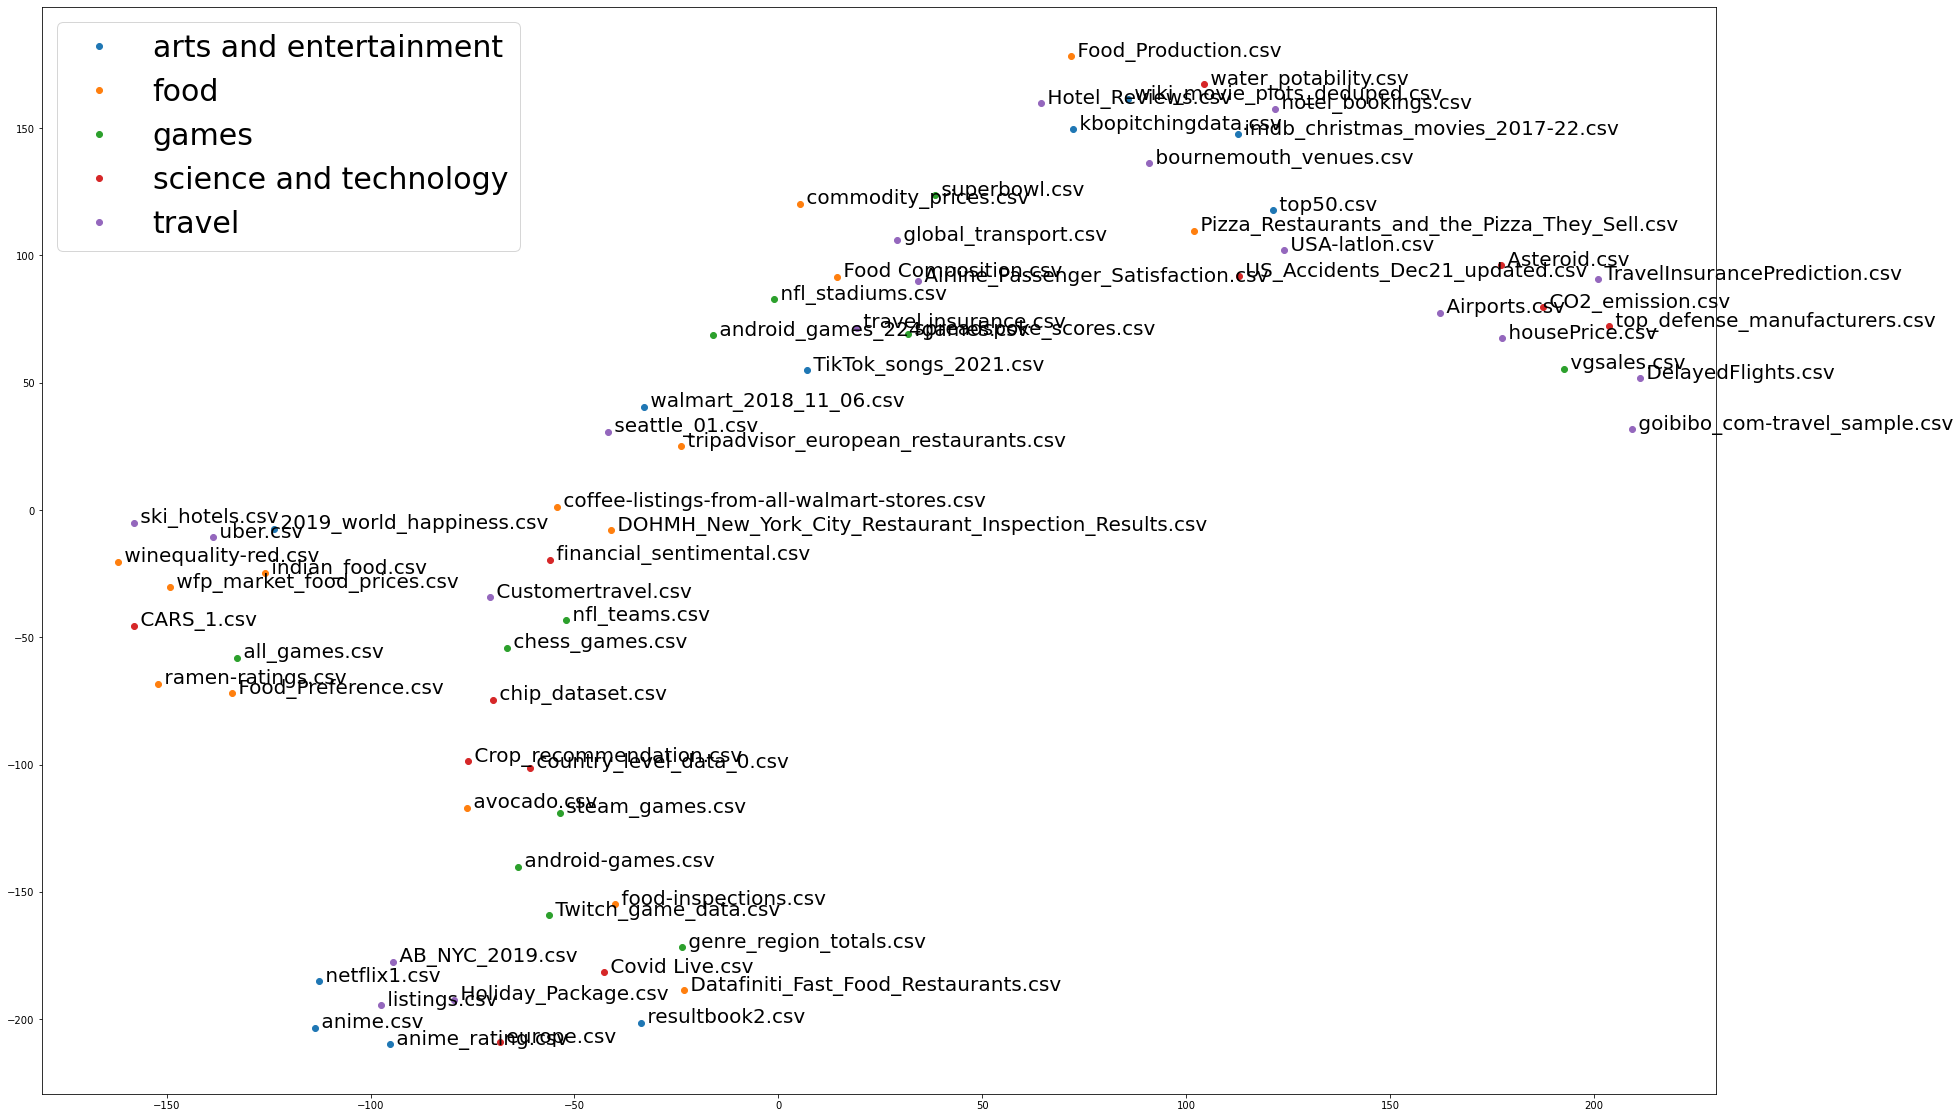

In [42]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
Final_df=pd.DataFrame(desc,index=Final_data["dataset"],columns=['x','y'])
fig = plt.figure()
fig.set_size_inches(30, 20) 
ax = fig.add_subplot(1, 1, 1)

Final_df2=Final_data.drop(columns="tag")
Final_df2
groups= Final_df2.groupby('category')
for name,group in groups:
    ax.plot(group.x,group.y,marker='o', linestyle='',label=name)
ax.legend(fontsize=30)
    
#ax.scatter(Final_data['x'], Final_data['y'])
for word, pos in Final_df.iterrows():
    ax.annotate(word, pos, fontsize=20)
plt.show()

In [43]:
pd.read_csv("/home/jhin/Attention/Datasets_YS/anime.csv")

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [44]:
import seaborn as sns
zero_data = np.zeros(shape=(len(data),len(data)))
cos_array = pd.DataFrame(zero_data, columns=file_list)
cos_array.index=[file_list]
for i in range(len(data)):
    for j in range(len(data)):
        A = result_vector[i].tolist()
        B = result_vector[j].tolist()
        cos_array.iloc[i,j]=cos_sim(A,B)
cos_array


,TravelInsurancePrediction.csv,Covid Live.csv,indian_food.csv,android_games_224games.csv,food-inspections.csv,Food Composition.csv,seattle_01.csv,netflix1.csv,commodity_prices.csv,kbopitchingdata.csv,...,europe.csv,Airline_Passenger_Satisfaction.csv,DelayedFlights.csv,genre_region_totals.csv,uber.csv,bournemouth_venues.csv,housePrice.csv,Airports.csv,walmart_2018_11_06.csv,Datafiniti_Fast_Food_Restaurants.csv
TravelInsurancePrediction.csv,1.000000,0.828595,0.051634,0.858702,0.889044,0.219772,0.794095,0.853891,0.828009,0.518608,...,0.673298,0.945335,0.169164,0.729103,0.789442,0.814905,0.888251,0.859388,0.892030,0.749078
Covid Live.csv,0.828595,1.000000,0.118671,0.808310,0.793259,0.530638,0.931438,0.751340,0.960907,0.729620,...,0.493355,0.707700,0.564619,0.873365,0.904865,0.965552,0.911408,0.690507,0.903333,0.943468
indian_food.csv,0.051634,0.118671,1.000000,0.025892,0.115874,0.283544,0.021291,0.206011,0.181155,0.444338,...,0.335186,0.084544,0.350034,0.442746,0.289819,0.258277,0.116942,0.134316,0.037295,0.330809
android_games_224games.csv,0.858702,0.808310,0.025892,1.000000,0.857674,0.186114,0.866941,0.887605,0.863566,0.572546,...,0.579247,0.816919,0.269847,0.777365,0.775882,0.841925,0.896045,0.823922,0.934179,0.773133
food-inspections.csv,0.889044,0.793259,0.115874,0.857674,1.000000,0.063028,0.825184,0.944002,0.787077,0.455089,...,0.811668,0.903756,0.124119,0.622821,0.696172,0.758027,0.904654,0.904248,0.917339,0.661757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bournemouth_venues.csv,0.814905,0.965552,0.258277,0.841925,0.758027,0.573927,0.922066,0.716974,0.979304,0.805055,...,0.370302,0.670582,0.631737,0.955231,0.944096,1.000000,0.919596,0.651346,0.913951,0.988588
housePrice.csv,0.888251,0.911408,0.116942,0.896045,0.904654,0.338464,0.907461,0.878816,0.937019,0.657209,...,0.647576,0.809741,0.375548,0.826128,0.861088,0.919596,1.000000,0.836139,0.965324,0.860444
Airports.csv,0.859388,0.690507,0.134316,0.823922,0.904248,0.012640,0.725998,0.937941,0.716246,0.239970,...,0.816728,0.880860,0.134883,0.515414,0.622077,0.651346,0.836139,1.000000,0.861549,0.543510
walmart_2018_11_06.csv,0.892030,0.903333,0.037295,0.934179,0.917339,0.312057,0.919366,0.915468,0.928936,0.620151,...,0.631534,0.832996,0.345653,0.820770,0.868687,0.913951,0.965324,0.861549,1.000000,0.845204


In [45]:
for i in range(len(data)):
    for j in range(i,len(data)):
        if cos_array.iloc[i,j]>0.975:
            if i != j :
                print(f"{file_list[i]},{i} : {file_list[j]},{j} -> {cos_array.iloc[i,j]}")

seattle_01.csv,6 : listings.csv,28 -> 0.9838610951344308
commodity_prices.csv,8 : global_transport.csv,23 -> 0.9793036784654457
commodity_prices.csv,8 : wfp_market_food_prices.csv,26 -> 0.9793036784654459
commodity_prices.csv,8 : USA-latlon.csv,33 -> 0.9793036784654459
commodity_prices.csv,8 : Twitch_game_data.csv,36 -> 0.9774742508007745
commodity_prices.csv,8 : nfl_teams.csv,53 -> 0.9793036784654459
commodity_prices.csv,8 : bournemouth_venues.csv,64 -> 0.979303678465446
global_transport.csv,23 : wfp_market_food_prices.csv,26 -> 0.9999999999999999
global_transport.csv,23 : USA-latlon.csv,33 -> 0.9999999999999999
global_transport.csv,23 : winequality-red.csv,48 -> 0.9760681801051027
global_transport.csv,23 : nfl_teams.csv,53 -> 1.0
global_transport.csv,23 : US_Accidents_Dec21_updated.csv,57 -> 0.9813173773133114
global_transport.csv,23 : bournemouth_venues.csv,64 -> 1.0
global_transport.csv,23 : Datafiniti_Fast_Food_Restaurants.csv,68 -> 0.9885882375366596
ski_hotels.csv,25 : Pizza_Res

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


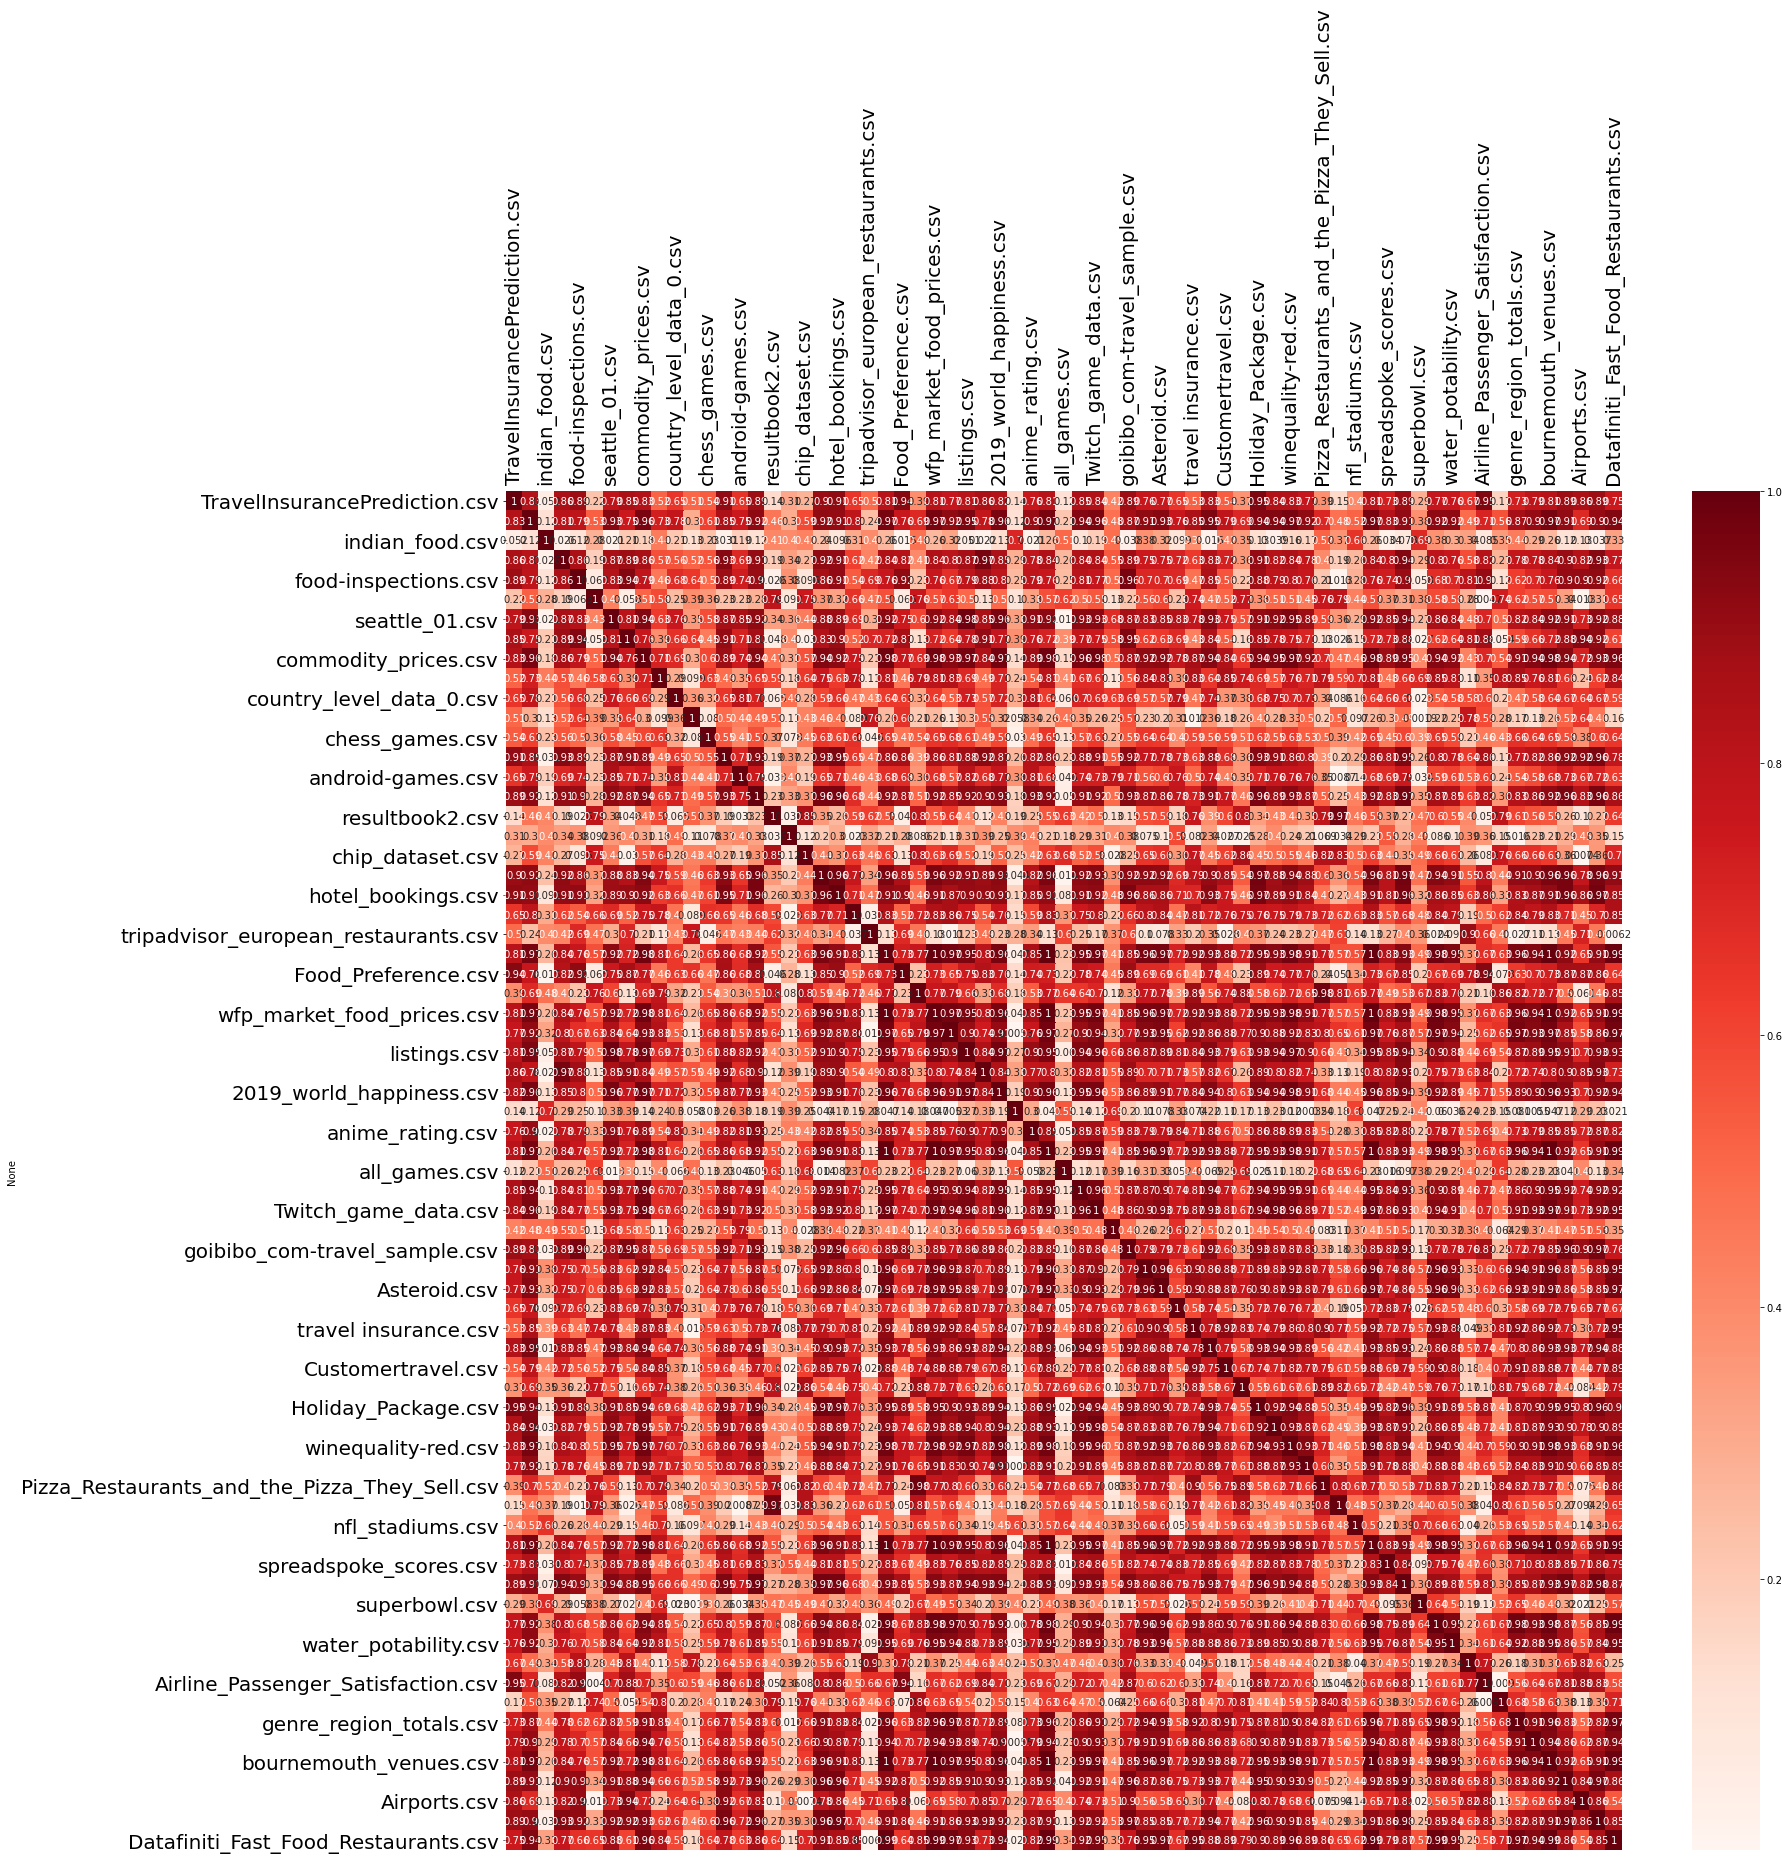

In [46]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(25,25))
plt.tick_params(axis='both', which='major', labelsize=20, labelbottom = False, bottom=False, top = False, labeltop=True)
sns.heatmap(cos_array, annot = True, cmap = 'Reds')

In [47]:
pd.read_csv('/home/jhin/Attention/Datasets_YS/bournemouth_venues.csv', encoding = 'ISO-8859-1')

,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,South Coast Roast,Coffee Shop,50.720913,-1.879085
1,DelMarco,Italian Restaurant,50.721370,-1.877221
2,Lower Gardens,Park,50.719323,-1.878195
3,Bournemouth Gardens,Park,50.718990,-1.877733
4,Bournemouth Square,Plaza,50.720156,-1.879563
...,...,...,...,...
95,Platform 1,Platform,50.727287,-1.863021
96,The Cliffeside Hotel,Hotel,50.719454,-1.860052
97,The Garden Restaurant - Cottonwood Boutique Hotel,Hotel,50.719795,-1.858884
98,Middle Chine,Beach,50.715090,-1.895664


In [48]:
pd.read_csv('/home/jhin/Attention/Datasets_YS/top_defense_manufacturers.csv', encoding = 'ISO-8859-1')

,this_year_rank,last_year_rank,company,leadership,country,2020_defense_revenue,2019_defense_revenue,%_defense_revenue_change,2020_total_revenue,revenue_fom_defense
0,1,1,Lockheed Martin 1 2,"James D. Taiclet, Chairman, President and CEO",U.S.,"$62,562.00","$56,606.00",11%,"$65,398.00",96%
1,2,NEW,Raytheon Technologies 3,"Greg Hayes, CEO and Executive Chairman",U.S.,"$42,000.00",NaN,NaN,"$65,000.00",65%
2,3,2,Boeing 4,"David Calhoun, President and CEO",U.S.,"$32,400.00","$34,300.00",-6%,"$58,158.00",56%
3,4,4,Northrop Grumman,"Kathy J. Warden, Chairman, CEO and President",U.S.,"$31,400.00","$28,600.00",10%,"$36,799.00",85%
4,5,3,General Dynamics 5,"Phebe Novakovic, Chairman and CEO",U.S.,"$29,800.00","$29,512.00",1%,"$37,900.00",79%
...,...,...,...,...,...,...,...,...,...,...
95,96,84,Peraton 27,"Stu Shea, Chairman, President and CEO",U.S.,$651.20,$631.29,3%,"$1,034.06",63%
96,97,NEW,Ukroboronprom,"Yuriy Husyev, Director General",Ukraine,$650.61,$764.98,-15%,"$1,379.95",47%
97,98,82,Cubic Corporation,"Bradley H. Feldmann, Chairman, President and CEO",U.S.,$634.70,$646.70,-2%,"$1,476.00",43%
98,99,NEW,Spirit AeroSystems,"Tom Gentile, President and CEO",U.S.,$613.00,NaN,NaN,"$3,405.00",18%


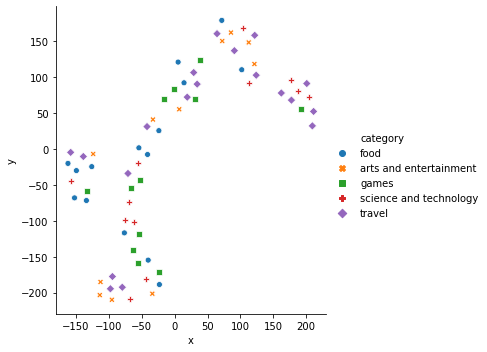

In [49]:
sns.relplot(x = 'x', y = 'y', hue = 'category', style = 'category', data = Final_data)

In [50]:
coord = []
for i in range(len(Final_data)):
    coord.append((Final_data['x'][i], Final_data['y'][i]))

In [51]:
Metacritic = coord[264]
Sale = coord[265]
Youtube = coord[266]
print('Metacritic~Sale :', cos_sim(Metacritic, Sale))
print('Metacritic~Youtube :', cos_sim(Metacritic, Youtube))
print('Sale~Youtube :', cos_sim(Sale, Youtube))

import matplotlib.pyplot as plt

graph = []
graph.append(list(Metacritic))
graph.append(list(Sale))
graph.append(list(Youtube))
print(graph)

x, y = zip(*graph)
plt.scatter(x, y)
plt.annotate('Metacritic', Metacritic)
plt.annotate('Sale', Sale)
plt.annotate('Youtube', Youtube)
plt.show()

IndexError: list index out of range

In [ ]:
michelin = coord[120]
hotel = coord[262]
friends = coord[71]

print('michelin~hotel :', cos_sim(michelin, hotel))
print('michelin~Youtube :', cos_sim(michelin, friends))
print('hotel~friends :', cos_sim(hotel, friends))

graph = []
graph.append(list(michelin))
graph.append(list(hotel))
graph.append(list(friends))
print(graph)

x, y = zip(*graph)
plt.scatter(x, y)
plt.annotate('michelin', michelin)
plt.annotate('hotel', hotel)
plt.annotate('friends', friends)
plt.show()

In [ ]:
holywood = coord[217]
imdb = coord[219]
plot = coord[128]

print('holywood~imdb :', cos_sim(holywood, imdb))
print('holywood~plot :', cos_sim(holywood, plot))
print('imdb~plot :', cos_sim(imdb, plot))

graph = []
graph.append(list(holywood))
graph.append(list(imdb))
graph.append(list(plot))
print(graph)

x, y = zip(*graph)
plt.scatter(x, y)
plt.annotate('holywood', holywood)
plt.annotate('imdb', imdb)
plt.annotate('plot', plot)
plt.show()

In [ ]:
fastfood = coord[120]
menu = coord[262]
sell = coord[71]

print('fastfood~menu :', cos_sim(fastfood, menu))
print('fastfood~sell :', cos_sim(fastfood, sell))
print('menu~sell :', cos_sim(menu, sell))

graph = []
graph.append(list(fastfood))
graph.append(list(menu))
graph.append(list(sell))
print(graph)

x, y = zip(*graph)
plt.scatter(x, y)
plt.annotate('fastfood', fastfood)
plt.annotate('menu', menu)
plt.annotate('sell', sell)
plt.show()

In [ ]:
def average(p, q):
    average_vec = np.zeros(shape = 768)
    for i in range(p, q):
        average_vec += result_vector[i].tolist()
    average_vec /= len(result_vector)
    return average_vec

In [ ]:
# arts : 0~56, food : 57~109 games : 110~157 science : 158~212, travel : 213~263
average_arts = average(0, 6)
average_food = average(6, 12)
average_games = average(12, 18)
average_science = average(18, 24)
average_travel = average(24, 30)

In [ ]:
is_arts = Final_data['category'] == 'arts and entertainment'
arts_index = Final_data[is_arts]
arts_vec = ((model_head.wv.get_vector('arts'))+model_head.wv.get_vector('entertainment'))/2
arts_vec = np.array(arts_vec)
arts_list = []
for i in range(len(arts_index)):
    try :
        rec_vec = result_vector[i].detach().numpy()
    except KeyError:
        continue
    arts_list.append(cos_sim(arts_vec, rec_vec))
arts_index.insert(5, 'similarity', arts_list)    

In [ ]:
is_science = Final_data['category'] == 'science and technology'
science_index = Final_data[is_science]
science_vec = ((model_head.wv.get_vector('science'))+model_head.wv.get_vector('technology'))/2
science_vec = np.array(science_vec)
science_list = []
for i in range(len(science_index)):
    try :
        rec_vec = result_vector[i].detach().numpy()
    except KeyError:
        continue
    science_list.append(cos_sim(science_vec, rec_vec))
science_index.insert(5, 'similarity', science_list) 

In [ ]:
is_games = Final_data['category'] == 'games'
games_index = Final_data[is_games]
games_vec = model_head.wv.get_vector('game')
games_vec = np.array(games_vec)
games_list = []
for i in range(len(games_index)):
    try :
        rec_vec = result_vector[i].detach().numpy()
    except KeyError:
        continue
    games_list.append(cos_sim(games_vec, rec_vec))
games_index.insert(5, 'similarity', games_list) 

In [ ]:
is_food = Final_data['category'] == 'food'
food_index = Final_data[is_food]
food_vec = model_head.wv.get_vector('food')
food_vec = np.array(food_vec)
food_list = []
for i in range(len(food_index)):
    try :
        rec_vec = result_vector[i].detach().numpy()
    except KeyError:
        continue
    food_list.append(cos_sim(food_vec, rec_vec))
food_index.insert(5, 'similarity', food_list) 

In [ ]:
is_travel = Final_data['category'] == 'travel'
travel_index = Final_data[is_travel]
travel_vec = model_head.wv.get_vector('travel')
travel_vec = np.array(travel_vec)
travel_list = []
for i in range(len(travel_index)):
    try :
        rec_vec = result_vector[i].detach().numpy()
    except KeyError:
        continue
    travel_list.append(cos_sim(travel_vec, rec_vec))
travel_index.insert(5, 'similarity', travel_list) 

In [ ]:
sorted_arts = sorted(arts_list, reverse=True)
sorted_science = sorted(science_list, reverse=True)
sorted_games = sorted(games_list, reverse=True)
sorted_food = sorted(food_list, reverse=True)
sorted_travel = sorted(travel_list, reverse=True)

In [ ]:
food_index[['dataset','category','similarity']].set_index('dataset')

In [ ]:
arts_index[['dataset','category','similarity']].set_index('dataset')

In [ ]:
games_index[['dataset','category','similarity']].set_index('dataset')

In [ ]:
science_index[['dataset','category','similarity']].set_index('dataset')

In [ ]:
travel_index[['dataset','category','similarity']].set_index('dataset')

In [ ]:
relevance = pd.read_csv('/home/jhin/Attention/Dataset_rel_YS_Category.csv')

In [ ]:
rel_arts_TF = relevance['category'] == 'arts and entertainment'
rel_arts = sorted(relevance[rel_arts_TF]['relevance'], reverse=True)
rel_science_TF = relevance['category'] == 'science and technology'
rel_science = sorted(relevance[rel_science_TF]['relevance'], reverse=True)
rel_games_TF = relevance['category'] == 'games'
rel_games = sorted(relevance[rel_games_TF]['relevance'], reverse=True)
rel_food_TF = relevance['category'] == 'food'
rel_food = sorted(relevance[rel_food_TF]['relevance'], reverse=True)
rel_travel_TF = relevance['category'] == 'travel'
rel_travel = sorted(relevance[rel_travel_TF]['relevance'], reverse=True)

In [ ]:
def NDCG(p, rel, cal):
    dcg = 0.0
    idcg = 0.0
    for i in range(p):
        idcg += cal[i]/np.log2(i+2)
    for i in range(p):
        dcg += rel[i]/np.log2(i+2)
    return dcg/idcg

In [ ]:
arts = NDCG(5, arts_list, sorted_arts)
science = NDCG(5, science_list, sorted_science)
games = NDCG(5, games_list, sorted_games)
food = NDCG(5, food_list, sorted_food)
travel = NDCG(5, travel_list, sorted_travel)

In [ ]:
print("arts", NDCG(5, arts_list, sorted_arts))
print("science", NDCG(5, science_list, sorted_science))
print("games", NDCG(5, games_list, sorted_games))
print("food", NDCG(5, food_list, sorted_food))
print("travel", NDCG(5, travel_list, sorted_travel))
print("total", (arts+science+games+food+travel)/5)